In [141]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import os

In [142]:
import skimage.filters
import skimage.io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy import ndimage as ndi
import pandas as pd
from sklearn.cluster import KMeans

# [IAPR][iapr]: Project

**Release date:** 27.04.2023


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

In this project, you will be working on solving tiling puzzles using image analysis and pattern recognition techniques. Tiling puzzles are a classic type of puzzle game that consists of fitting together pieces of a given shape (in this case squared to form a complete image. The goal of this project is to develop an algorithm that can automatically reconstruct tiling puzzles from a single input image. 

---

## 1. Data

### Input data
To achieve your task, you will be given images that look like this:


![train_00.png](data_project/project_description/train_00.png)

### Example puzzle content
Example of input of solved puzzles. 
Solution 1
<img src="data_project/project_description/solution_example.png" width="512"/>
Solution 2
<img src="data_project/project_description/solution_example2.jpg" width="512"/>


### 1.1. Image layout

- The input for the program will be a single image with a size of __2000x2000 pixels__, containing the pieces of the tiling puzzles randomly placed in it. The puzzles sizes vary from __3x3, 3x4, or 4x4__ size. 
    -__You are guaranteed to always have the exact number of pieces for each puzzle__ 
        -For each puzzle you always are expected to find exaclty 9,12,16 pieces
        -If you find something else, either you are missing pieces, or added incorrect pieces for the puzzle

- The puzzle pieces are square-shaped with dimensions of 128x128 pixels (before rotation). 

- The input image will contain pieces from __two or three (but never four)__ different tiling puzzles, as well as some __extra pieces (outliers)__ that do not belong to either puzzle.


## 2. Tasks (Total 20 points) 


The project aims to:
1) Segment the puzzle pieces from the background (recover the pieces of 128x128 pixels)   \[ __5 points__ \] 

2) Extract features of interest from puzzle pieces images \[ __5 points__ \]   

3) Cluster puzzle pieces to identify which puzzle they belong, and identify outliers.  \[ __5 points__ \]   

4) Solve tiling puzzle (find the rotations and translations to correctly allocate the puzzle pieces in a 3x3, 3x4 or 4x4 array.) \[ __5 points__ \]   

##### The images used for the puzzles have self-repeating patterns or textures, which ensures that all puzzle pieces contain more or less the same features regardless of how they were cut. 




### 1.2. Output solution pieces.

For each inpute image, the output solution will include N images with solved puzzles, where N is the number of puzzles in the input image. and M images, that are Each of these images will contain the solved solution to one of the N puzzles in the input. 


-  Example input:  train_05.png

- Example solution:
        -solution_05_00.png solution_05_01.png solution_05_02.png 
        -outlier_05_00.png outlier_05_01.png outlier_05_02.png ...

- Example input:  train_07.png
- Example solution:
        -solution_07_00.png solution_07_01.png 
        -outlier_07_00.png outlier_07_01.png outlier_07_02.png ...


__Watch out!__ output resolution should always be like this:  
<table ><tr><th >Puzzle pieces <th><th> pixel dimentions <th> <th> pixel dimentions <th> <tr>
<tr><td> 3x3 <td><td> 384x384 <td><td> 3(128)x3(128) <td> <tr>
<tr><td> 3x4 <td><td> 384x512 <td><td> 3(128)x4(128)<tr>
<tr><td> 4x4 <td><td> 512x512 <td><td> 4(128)x4(128)<tr>
<tr><td> 1x1 (outlier)<td><td> 128x128 <td><td> (1)128x(1)128 <td><tr><table>





__Order of the solutions (and rotations) it's not a problem for the grading__




the output solution will be a final image of resolution (1283)x(1283), with each piece correctly placed in its corresponding location in the 3x3 array. Similarly, if the puzzle consists of 3x4 or 4x4 pieces, the output solution will be an image of resolution (1283)x(1284) or (1284)x(1284)



### 1.3 Data folder Structure

You can download the data for the project here: [download data](https://drive.google.com/drive/folders/1k3xTH0ZhpqZb3xcZ6wsOSjLzxBNYabg3?usp=share_link)

```
data_project
│
└─── project_description
│    │    example_input.png      # example input images
│    │    example_textures1.png      # example input images
│    │    example_textures2.png      # example input images
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.png        # Train image 00
│    │    ...
│    │    train_16.png        # Train image 16
│    └─── train_labels.csv    # Ground truth of the train set
|    
└────train_solution
│    │    solution_00_00.png        # Solution puzzle 1 from Train image 00
│    │    solution_00_01.png        # Solution puzzle 2 from Train image 00
│    │    solution_00_02.png        # Solution Puzzle 3 from Train image 00
│    │    outlier_00_00.png         # outlier     from Train image 00
│    │    outlier_00_01.png         # outlier     from Train image 00
│    │    outlier_00_03.png         # outlier     from Train image 00
│    │    ...
│    │    solution_15_00.png        # Solution puzzle 1 from Train image 15
│    │    solution_15_01.png        # Solution puzzle 2 from Train image 15
│    │    outlier_15_00.png         # outlier     from Train image 15
│    └─── outlier_15_01.png         # outlier     from Train image 15
│
└─── test
     │    test_00.png         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx.png             # Test image xx (day of the exam only)
```



## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** (test folder) with few images, but **no ground truth** (no solutions).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_solution** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

In [143]:
## load images
import os 
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
from skimage.filters import gabor, gabor_kernel
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from skimage.feature import local_binary_pattern
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.measure import regionprops
from scipy.ndimage import binary_fill_holes
from math import sqrt
import pandas as pd


In [144]:
def load_input_image(image_index ,  folder ="train" , path = "data_project"):
    
    filename = "train_{}.png".format(str(image_index).zfill(2))
    path_solution = os.path.join(path,folder , filename )
    
    im= Image.open(os.path.join(path,folder,filename)).convert('RGB')
    im = np.array(im)
    return im

def save_solution_puzzles(image_index , solved_puzzles, outliers  , folder ="train" , path = "data_project"  ,group_id = 0):
    
    path_solution = os.path.join(path,folder + "_solution_{}".format(str(group_id).zfill(2)))
    if not  os.path.isdir(path_solution):
        os.mkdir(path_solution)

    print(path_solution)
    for i, puzzle in enumerate(solved_puzzles):
        filename =os.path.join(path_solution, "solution_{}_{}.png".format(str(image_index).zfill(2), str(i).zfill(2)))
        Image.fromarray(puzzle).save(filename)

    for i , outlier in enumerate(outliers):
        filename =os.path.join(path_solution, "outlier_{}_{}.png".format(str(image_index).zfill(2), str(i).zfill(2)))
        Image.fromarray(outlier).save(filename)


In [145]:
def solve_and_export_puzzles_image(image_index , folder = "train" , path = "data_project"  , group_id = "00"):
    """
    Wrapper funciton to load image and save solution
            
    Parameters
    ----------
    image:
        index number of the dataset

    Returns
    """

      # open the image
    image_loaded = load_input_image(image_index , folder = folder , path = path)
    #print(image_loaded)
    
   
    ## call functions to solve image_loaded
    solved_puzzles = [ (np.random.rand(512,512,3)*255).astype(np.uint8)  for i in range(2) ]
    outlier_images = [ (np.random.rand(128,128,3)*255).astype(np.uint8) for i in range(3)]
    
    save_solution_puzzles (image_index , solved_puzzles , outlier_images , folder = folder ,group_id =group_id)
    
   
    
    
    
    return image_loaded , solved_puzzles , outlier_images

im, sol , out = solve_and_export_puzzles_image(6 , group_id = 6)

data_project\train_solution_06

(2000, 2000, 3)

Text(0.5, 1.0, 'Loaded Image')

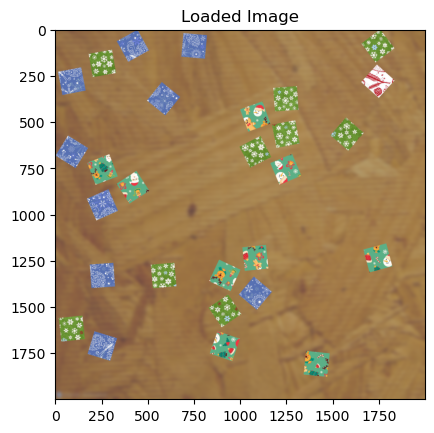

In [146]:
image_number = 0
image_loaded = load_input_image(image_number, folder="train", path="data_project")
print(image_loaded.shape)
plt.figure()
plt.imshow(image_loaded)
plt.title('Loaded Image')

# Preprocessing steps:

### Applying Median Blurring:
The central element of the image is replaced by the median value calculated from all the pixels within the kernel area. By doing so, the Median blur effectively reduces noise in the image while preserving edges and details.


### Laplacian of Gaussian (LOG):
We applied LoG for edge detection.


### Image Thresholding: 
We applied image thresholding for converting to binray image.


### Mathematical Morphology: 
Closing operator is applied in order to make the contours easier to detect by filling the contours of puzzle.


In [147]:
def preprocess_image(image):
    return cv2.medianBlur(image, ksize=7)

In [148]:
def enhance_edges(image):
    return cv2.Laplacian(image, cv2.CV_8U, ksize=3)

In [149]:
def threshold_image(image):
    _, binary_image = cv2.threshold(image, 8, 255, cv2.THRESH_BINARY)
    return binary_image

In [150]:
def close_edges(image):
    kernel = np.ones((9, 9), np.uint8)
    closed_edges = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return cv2.cvtColor(closed_edges, cv2.COLOR_BGR2GRAY)

### Extract and Segment Puzzle Pieces:


The function `find_puzzle_contours(image)` takes an image as input and uses the OpenCV function `cv2.findContours()` to detect contours in the image. It returns the list of contours (boundaries) found.


The function `filter_puzzle_pieces(contours)` takes the list of contours as input and filters out the puzzle pieces based on their area. It approximates each contour using `cv2.approxPolyDP()` and checks if the contour area falls within a specific range. It returns the filtered puzzle pieces.


The function `extract_puzzle_pieces(image, puzzle_pieces)` takes the original image and the puzzle pieces as input. It resizes the image to its original size and extracts each puzzle piece individually. It calculates the rotated bounding box of each puzzle piece, applies rotation and cropping operations, and returns the extracted puzzle images.


In [151]:
def find_puzzle_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [152]:
def filter_puzzle_pieces(contours):
    puzzle_pieces = []
    for contour in contours:
        epsilon = 0.08 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if cv2.contourArea(approx) >= (128 * 128 * 0.8) and cv2.contourArea(approx) <= (128 * 128 * 1.2):
            puzzle_pieces.append(approx)
    return puzzle_pieces

In [153]:
def extract_puzzle_pieces(image, puzzle_pieces):
    resized_image = cv2.resize(image, (image.shape[1], image.shape[0]))
    puzzle_images = []
    for piece in puzzle_pieces:
        rect = cv2.minAreaRect(piece)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        width = int(rect[1][0])
        height = int(rect[1][1])
        angle = rect[2]
        M = cv2.getRotationMatrix2D(rect[0], angle, 1)
        rotated_image = cv2.warpAffine(resized_image, M, (resized_image.shape[1], resized_image.shape[0]))
        puzzle_piece = cv2.getRectSubPix(rotated_image, (width, height), rect[0])
        puzzle_images.append(puzzle_piece)
    return puzzle_images

In [154]:
def segment_puzzle_pieces(image):
    preprocessed_image = preprocess_image(image)
    enhanced_edges = enhance_edges(preprocessed_image)
    binary_image = threshold_image(enhanced_edges)
    closed_edges = close_edges(binary_image)
    
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    dilated_mask = cv2.dilate(closed_edges.astype(np.uint8), dilation_kernel, iterations=2)
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed_mask = cv2.morphologyEx(dilated_mask.astype(np.uint8), cv2.MORPH_CLOSE, closing_kernel, iterations=5)
    eroded_mask = binary_fill_holes(closed_mask).astype(np.uint8)
    
    contours = find_puzzle_contours(closed_edges)
    puzzle_pieces = filter_puzzle_pieces(contours)
    puzzle_images = extract_puzzle_pieces(preprocessed_image, puzzle_pieces)
    return puzzle_images, eroded_mask

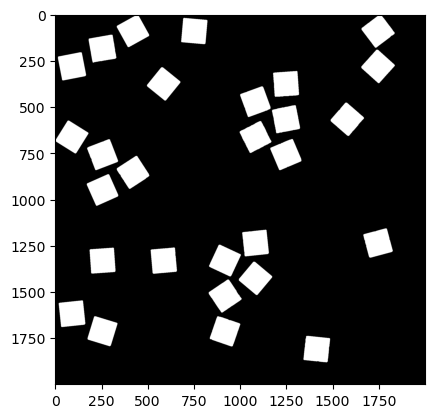

In [155]:
# Example usage:
puzzle_pieces, mask = segment_puzzle_pieces(image_loaded)
plt.imshow(mask, cmap = 'gray')
plt.show()

## Evaluation metrics

The evaluation metrics will be liberated in the following days. 


## Gabor filters

$$ gb(x,y) = \exp \left( -\frac{1}{2} \left( \frac{x_{\theta}^2}{\sigma^2} + \frac{y_{\theta}^2}{(\Gamma\sigma)^2} \right) \right) \cos \left( \frac{2 \pi}{\lambda} x_{\theta} + \psi \right) $$



## Feature Extraction

Gabor Features: 
Defines Gabor filter parameters. Iterates over frequencies and orientations. Applies Gabor filter to the grayscale image and computes statistical features such as mean, standard deviation, kurtosis, and skewness of the filter responses. Computes power spectrum features and adds them.

Local Binary Pattern (LBP):   An effective texture descriptor for images which thresholds the neighboring pixels based on the value of the current pixel

Shape features (number of contours). 

Spatial features (pixel intensity entropy).

Calculates gray-level co-occurrence matrix (GLCM) features (contrast, energy, correlation) for textures.

Converts the image to HSV color space. Calculates histograms for each channel (RGB and HSV) followed by flattening and normalizes the histograms.

We handled missing values, standardizes the features, and performs PCA for dimensionality reduction

In [156]:
def extract_gabor_features(image):

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define Gabor filter parameters
    orientations = 8  # Number of orientations
    frequencies = [0.1, 0.2, 0.3]  # List of frequencies
    gabor_features = []

    for frequency in frequencies:
        for theta in range(orientations):
            for sigma in (1,3):
                # Create Gabor filter
                gabor_filter = gabor(gray_image, frequency=frequency, theta=theta * np.pi / orientations, sigma_x= sigma, sigma_y= sigma)

                # Apply Gabor filter to the image and compute features
                filtered_image = np.real(gabor_filter)
                features = [np.mean(filtered_image), np.std(filtered_image), np.var(filtered_image), np.min(filtered_image), np.max(filtered_image), skew(filtered_image.flatten()),
                            kurtosis(filtered_image.flatten()), np.median(filtered_image)]

                # Compute power spectrum features
                power_spectrum = np.abs(np.fft.fft2(filtered_image)) ** 2
                power_spectrum /= np.sum(power_spectrum)  # Normalize the power spectrum
                power_spectrum_features = power_spectrum.flatten()[:8]  # Consider the first 8 coefficients
                features.extend(power_spectrum_features)

                # Add additional features (e.g., LBP)
                lbp_image = compute_lbp(gray_image)
                lbp_features = extract_lbp_features(lbp_image)
                features.extend(lbp_features)

                # Add the features to the list
                gabor_features.extend(features)

    return np.array(gabor_features)

def compute_lbp(image):
    # Compute LBP using skimage's local_binary_pattern function
    lbp_image = local_binary_pattern(image, 8, 1, method='uniform')
    return lbp_image

def extract_lbp_features(lbp_image):
    # Compute histogram of LBP values as features
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(10))
    return hist


def extract_color_histogram_features(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the histogram for each channel (R, G, B) in RGB space
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    # Calculate the histogram for each channel (H, S, V) in HSV space
    hist_h = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    # Flatten and normalize the histograms
    hist_r = hist_r.flatten() / np.sum(hist_r)
    hist_g = hist_g.flatten() / np.sum(hist_g)
    hist_b = hist_b.flatten() / np.sum(hist_b)
    hist_h = hist_h.flatten() / np.sum(hist_h)
    hist_s = hist_s.flatten() / np.sum(hist_s)
    hist_v = hist_v.flatten() / np.sum(hist_v)

    # Concatenate the histograms as features
    color_histogram_features = np.concatenate((hist_r, hist_g, hist_b, hist_h, hist_s, hist_v))

    return color_histogram_features

# Example usage:
puzzle_piece_features = []
num_puzzle_pieces = len(puzzle_pieces)
num_rows = (num_puzzle_pieces + 2) // 3  # Calculate the number of rows for subplots
num_cols = min(num_puzzle_pieces, 3)  # Set the number of columns for subplots to a maximum of 3

for i, puzzle_piece in enumerate(puzzle_pieces):
    # Assuming puzzle_piece is the cropped puzzle piece image

    # Extract Gabor filter features
    gabor_features = extract_gabor_features(puzzle_piece)

    # Extract color histogram features
    color_histogram_features = extract_color_histogram_features(puzzle_piece)

    # Combine all feature sets
    features = np.concatenate((gabor_features, color_histogram_features))

    puzzle_piece_features.append(features)

C:\Users\faghih\AppData\Local\Temp\ipykernel_9696\3687420682.py:24: RuntimeWarning: invalid value encountered in true_divide
  power_spectrum /= np.sum(power_spectrum)  # Normalize the power spectrum


## Feature Engineering

In [157]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
imputed_features = imputer.fit_transform(puzzle_piece_features)

# Standardize the features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Specify the desired number of components
reduced_features = pca.fit_transform(standardized_features)

## Clustering

Perform clustering using `KMeans` algorithm and find the optimal number of clusters based on `silhouette scores`.

Set a threshold for outlier identification and then identify outliers based on cluster size and proximity to cluster centroid.

We also add our prior knowledge (number pieces in each cluster) to our algorithms such that:

- If cluster size < 9, all points in the cluster are outliers
- If cluster size > 16, we take only the closest 16 points to the centroid
- If 12 < cluster size < 16, we take only the closest 12 points to the centroid
- If 9 < cluster size < 12, we take only the closest 9 points to the centroid

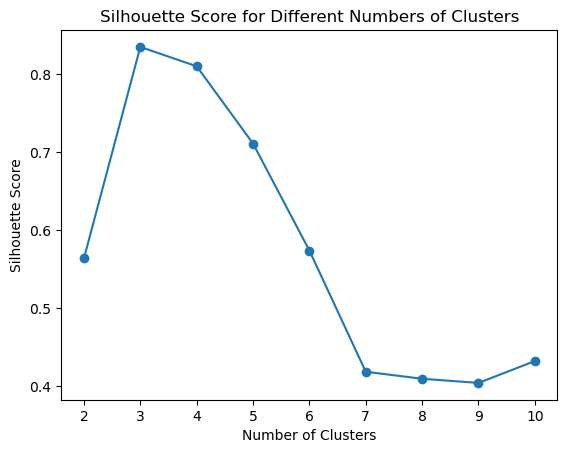

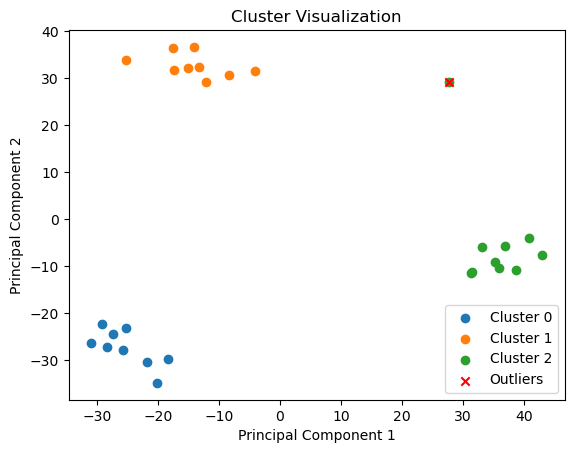

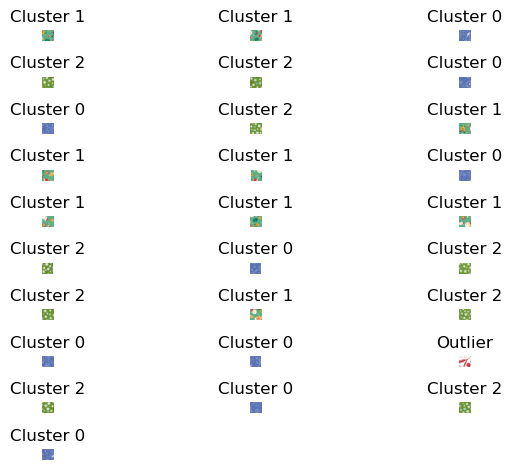

In [158]:
# Perform clustering using KMeans and determine the optimal number of clusters
max_clusters = 10  # Maximum number of clusters to try
silhouette_scores = []  # List to store silhouette scores

for num_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# Find the optimal number of clusters based on the elbow point (maximum silhouette score)
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Add 2 to the index to get the actual number of clusters

# Perform clustering using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters)
cluster_labels = kmeans.fit_predict(reduced_features)

# Get the unique cluster labels
unique_labels = np.unique(cluster_labels)

# Calculate silhouette scores for each sample
silhouette_scores = silhouette_samples(reduced_features, cluster_labels)

# Set a threshold for outlier identification
silhouette_threshold = -0.2

# Initialize a list to store outlier indices
outlier_indices = []

# Iterate over each cluster
for label in unique_labels:
    cluster_data = reduced_features[cluster_labels == label]
    cluster_size = len(cluster_data)

    # Check cluster size
    if cluster_size < 9:
        # All points in the cluster are outliers
        outlier_indices.extend(np.where(cluster_labels == label)[0])
    elif cluster_size not in [9, 12, 16]:
        centroid = kmeans.cluster_centers_[label]

        if cluster_size > 16:
            # Take only the closest 16 points to the centroid
            distances = np.linalg.norm(cluster_data - centroid, axis=1)
            closest_indices = np.argsort(distances)[:17]
            outlier_indices.extend(np.where(cluster_labels == label)[0][closest_indices[16:]])
        elif 12 < cluster_size < 16:
            # Take only the closest 12 points to the centroid
            distances = np.linalg.norm(cluster_data - centroid, axis=1)
            closest_indices = np.argsort(distances)[:13]
            outlier_indices.extend(np.where(cluster_labels == label)[0][closest_indices[12:]])
        elif 9 < cluster_size < 12:
            # Take only the closest 9 points to the centroid
            distances = np.linalg.norm(cluster_data - centroid, axis=1)
            closest_indices = np.argsort(distances)[:10]
            outlier_indices.extend(np.where(cluster_labels == label)[0][closest_indices[9:]])

# Convert the outlier indices to a NumPy array of integers
outlier_indices = np.array(outlier_indices, dtype=int)

# Visualize the clusters and outliers
for label in unique_labels:
    cluster_data = reduced_features[cluster_labels == label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label}')

# Plot the outliers with a different marker and color
outlier_data = reduced_features[outlier_indices]
plt.scatter(outlier_data[:, 0], outlier_data[:, 1], marker='x', color='red', label='Outliers')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

# Plot the puzzle pieces with their assigned cluster colors
plt.figure()
for i, puzzle_piece in enumerate(puzzle_pieces):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(puzzle_piece)
    if i in outlier_indices:
        plt.title(f'Outlier')
    else:
        plt.title(f'Cluster {cluster_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [159]:
outlier_images = []
cluster_images = []
resized_images = []
cluster_labels_new = []

for i, puzzle_piece in enumerate(puzzle_pieces):
    resized = cv2.resize(puzzle_piece, (128, 128))
    if i in outlier_indices:
        outlier_images.append(resized)
    else:
        cluster_images.append(resized)
        cluster_labels_new.append(cluster_labels[i])

cluster_dict = {}
for image, label in zip(cluster_images, cluster_labels_new):
    if label not in cluster_dict:
        # Create a new list for the cluster label if it doesn't exist
        cluster_dict[label] = []

    # Append the image to the corresponding cluster list
    cluster_dict[label].append(image)

# Add outliers as a separate cluster
cluster_dict['Outliers'] = outlier_images

# Convert the dictionary values (lists) to numpy arrays
cluster_lists = [np.array(cluster) for cluster in cluster_dict.values()]

In [160]:
###
import numpy as np 
import matplotlib.pyplot as plt
from rich import print
from rich.progress import track
from rich.console import Console
from icecream import ic
import os
###
from PIL import Image

def export_solutions(image_index , solutions , path = "data_project"  , group_id = "00"):
    """
    Wrapper funciton to load image and save solution

    solutions :
        image_index : index of the image to solve

        list with the following items
        solutions [0] = segmented mask of the puzzle (matrix of 2000x2000 dimentions) , 0 for background, 1 for puzzle piece 
        
        solutions [1] = matrix containing the features of the puzzles.  if there were  N pieces in the puzzle, and you extracted M Features per puzzle piece, then the feature map should be of size N x M

        solutions [2] =  list of lists of images, each list of images is a cluster of puzzle pieces. (it includes outliers as the last elementof the list)
                        If there are k clusters, then the list should have k elements, each element is a list
                        e.g. 

                    solution [2] [0] =  [cluster0_piece0 , cluster0_piece1 ...]
                    solution [2] [1] =  [cluster1_piece0 , cluster1_piece1 ...]
                    solution [2] [2] =  [cluster2_piece0 , cluster2_piece1 ...]
                    ....
                    solution [2] [k]   =  [clusterk_piece0 , clusterk_piece1 ... ]
                    solution [2] [k+1] = [ outlier_piece0, outlier_piece1 ...]
                        
    solutions [3] = list of images containing the puzzles
                    e.g.
                    solution [3] [0] =  solved_puzzle0 (image of 128*3 x 128*4)
                    solution [3] [1] =  solved_puzzle1 (image of 128*4 x 128*4)
                    solution [3] [2] =  solved_puzzle2 (image of 128*3 x 128*3)
                    ....



        folder : folder where the image is located, the day of the exam it will be "test"
        path : path to the folder where the image is located

        group_id : group id of the team
            
    ----------
    image:
        index number of the dataset

    Returns
    """
    
    saving_path = os.path.join(path , "solutions_group_" + str(group_id) )
    if not os.path.isdir(saving_path):
        os.mkdir(saving_path)

    print("saving solutions in folder: " , saving_path)

   
    ## call functions to solve image_loaded
    save_mask           (image_index , solutions[0] , saving_path)
    save_feature_map    (image_index , solutions[1] , saving_path)
    save_cluster        (image_index , solutions[2] , saving_path)
    save_solved_puzzles (image_index , solutions[3] , saving_path)

    
    return None

def save_mask(image_index , solution, saving_path):
    
    filename = os.path.join(saving_path, f"mask_{str(image_index).zfill(2)}.png")
    if solution.shape[0] != 2000 or solution.shape[1] != 2000:
        print("error in mask:  shape of image" , solution.shape)
        return
    if np.max(solution) ==1:
        solution = solution*255
    solution = np.array(solution , dtype = np.uint8)
    Image.fromarray(solution).save(filename)
1
def save_feature_map(image_index , solution, saving_path):
    filename = os.path.join(saving_path, f"feature_map_{str(image_index).zfill(2)}.txt")
    np.savetxt(filename , solution)

    #min max into 0 ,255 interval
    solution = (solution - np.min(solution)) / (np.max(solution) - np.min(solution))
    solution = np.array(solution*255 , dtype = np.uint8)
    filename = filename.replace(".txt" , ".png")
    Image.fromarray(solution).save(filename)
    
def save_cluster(image_index , solution, saving_path):

    
    filename = os.path.join(saving_path, f"cluster_images_{str(image_index).zfill(2)}.png")

    n_clusters = len(solution)
    len_clusters = [len(cluster) for cluster in solution]


    xlen = n_clusters*128
    ylen = np.max(len_clusters)*128
    
    
    whole_image = np.zeros((xlen ,ylen , 3) , dtype = np.uint8)

    for i in range(n_clusters):
        for j in range(len_clusters[i]):
            if solution[i][j].shape[0] != 128 or solution[i][j].shape[1] != 128:
                print("error in shape of image" , solution[i][j].shape)
                return
            whole_image[i*128:(i+1)*128 , j*128:(j+1)*128 , :] = solution[i][j]
    
    Image.fromarray(whole_image).save(filename)

def save_solved_puzzles(image_index , solution, saving_path):

    n_solutions = len(solution)

    for i , sol in enumerate(solution):
        print(sol.shape)
        sol = np.array(sol , dtype = np.uint8)
        filename = os.path.join(saving_path, f"solved_puzzle_{str(image_index).zfill(2)}_{str(i).zfill(2)}.png")
        Image.fromarray(sol).save(filename)




#%%

solved_puzzle = [np.zeros((128*3,128*4,3)) + np.random.randint(0,254, size=3) for _ in range(3)]

solution = [mask, reduced_features, cluster_lists , solved_puzzle]

#saving solution for image 1
export_solutions(image_number,  solution, path = "data_project", group_id = "38")

saving solutions in folder:  data_project\solutions_group_38

(384, 512, 3)

(384, 512, 3)

(384, 512, 3)